In [5]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [6]:
from google.colab import files
uploaded = files.upload()


Saving Online Retail.xlsx to Online Retail (1).xlsx


In [7]:
InputPath = "Online Retail.xlsx"

In [8]:
# Step 1: Loading and Preprocessing Data

Data = pd.read_excel(InputPath)

NumCols     = Data.select_dtypes('number').columns

MissingVal  = Data.isna().any(axis = 1)
NegativeVal = (Data[NumCols] < 0).any(axis = 1)
ReturnVal   = Data['InvoiceNo'].astype(str).str.startswith('C')


good        = ~(MissingVal | NegativeVal | ReturnVal)
DataClean   = Data.loc[good].copy()


print("Rows before:", len(Data), "| Rows after:", len(DataClean), "| Rows removed:", (~good).sum())



Rows before: 541909 | Rows after: 397924 | Rows removed: 143985


In [9]:
# Step 2: Create an item-transaction matrix

DataUse               = DataClean.copy()
DataUse['InvoiceNo']  = DataUse['InvoiceNo'].astype(str)
DataUse['StockCode']  = DataUse['StockCode'].astype(str).str.strip()

AllInvoices           = sorted(DataUse['InvoiceNo'].unique().tolist())
AllItems              = sorted(DataUse['StockCode'].unique().tolist())

ItemTransactionMatrix = pd.DataFrame(0, index = AllInvoices, columns = AllItems, dtype = int)

InvoiceToItems = {}
for InvoiceNo, StockCode in zip(DataUse['InvoiceNo'], DataUse['StockCode']):
    if InvoiceNo not in InvoiceToItems:
        InvoiceToItems[InvoiceNo] = set()
    InvoiceToItems[InvoiceNo].add(StockCode)

for InvoiceNo, StockCode in InvoiceToItems.items():
    ItemTransactionMatrix.loc[InvoiceNo, list(StockCode)] = 1

print("Number of unique invoices:", len(AllInvoices))
print("Number of unique items:", len(AllItems))
print("Matrix shape:", ItemTransactionMatrix.shape)


Number of unique invoices: 18536
Number of unique items: 3665
Matrix shape: (18536, 3665)


In [10]:
# Step 3: Streaming Simulation

DataStream               = DataClean.copy()
DataStream['InvoiceNo']  = DataStream['InvoiceNo'].astype(str)
#DataStream['InvoiceDate'] = pd.to_datetime(DataStream['InvoiceDate'])

DataStream = DataStream.sort_values(['InvoiceDate', 'InvoiceNo'])

BatchSize  = 1000
TotalRows  = len(DataStream)
BatchCount = (TotalRows // BatchSize) + (1 if TotalRows % BatchSize else 0)

print(f"Total records: {TotalRows}")
print(f"Batch size: {BatchSize}")
print(f"Number of batches: {BatchCount}\n")

for i in range(BatchCount):
    start = i * BatchSize
    end   = min(start + BatchSize, TotalRows)

    CurrentBatch   = DataStream.iloc[start:end]
    CurrentInvoices = CurrentBatch['InvoiceNo'].unique().tolist()

    BatchData = ItemTransactionMatrix.loc[CurrentInvoices]

    print(f"Batch {i+1}/{BatchCount} → Rows {start+1}–{end} | BatchData shape: {BatchData.shape}")


Total records: 397924
Batch size: 1000
Number of batches: 398

Batch 1/398 → Rows 1–1000 | BatchData shape: (61, 3665)
Batch 2/398 → Rows 1001–2000 | BatchData shape: (69, 3665)
Batch 3/398 → Rows 2001–3000 | BatchData shape: (68, 3665)
Batch 4/398 → Rows 3001–4000 | BatchData shape: (69, 3665)
Batch 5/398 → Rows 4001–5000 | BatchData shape: (50, 3665)
Batch 6/398 → Rows 5001–6000 | BatchData shape: (40, 3665)
Batch 7/398 → Rows 6001–7000 | BatchData shape: (29, 3665)
Batch 8/398 → Rows 7001–8000 | BatchData shape: (44, 3665)
Batch 9/398 → Rows 8001–9000 | BatchData shape: (44, 3665)
Batch 10/398 → Rows 9001–10000 | BatchData shape: (56, 3665)
Batch 11/398 → Rows 10001–11000 | BatchData shape: (65, 3665)
Batch 12/398 → Rows 11001–12000 | BatchData shape: (48, 3665)
Batch 13/398 → Rows 12001–13000 | BatchData shape: (68, 3665)
Batch 14/398 → Rows 13001–14000 | BatchData shape: (51, 3665)
Batch 15/398 → Rows 14001–15000 | BatchData shape: (58, 3665)
Batch 16/398 → Rows 15001–16000 | Batc

In [11]:
# Step 4: Matrix monitoring with different algorithms
# Gaussian Random Projection (GRP)

np.random.seed(42)
k_grp   = 50
topm    = 5

d = ItemTransactionMatrix.shape[1]
G_grp = np.random.randn(d, k_grp) / np.sqrt(k_grp)

print("\n# Step 4-A: Gaussian Random Projection")
SVT_GRP = []
for i in range(BatchCount):
    start = i * BatchSize
    end   = min(start + BatchSize, TotalRows)

    CurrentBatch     = DataStream.iloc[start:end]
    CurrentInvoices  = CurrentBatch['InvoiceNo'].unique().tolist()
    X                = ItemTransactionMatrix.loc[CurrentInvoices].values.astype(float, copy=False)  # (nb,d)

    Z = X @ G_grp                                  # (nb, k_grp)
    s = np.linalg.svd(Z, full_matrices=False, compute_uv=False)   # σها
    SVT_GRP.append(s[:topm])

    print(f"Batch {i+1:>3}/{BatchCount} | {X.shape[0]}×{X.shape[1]}→{X.shape[0]}×{k_grp} | σ₁₋{topm}={np.round(s[:topm],4)}")



# Step 4-A: Gaussian Random Projection
Batch   1/398 | 61×3665→61×50 | σ₁₋5=[11.1286 10.3335  9.9892  8.7803  8.0645]
Batch   2/398 | 69×3665→69×50 | σ₁₋5=[11.1334  9.9116  8.5629  8.1734  7.8467]
Batch   3/398 | 68×3665→68×50 | σ₁₋5=[14.014  10.1833  8.9443  8.743   8.6344]
Batch   4/398 | 69×3665→69×50 | σ₁₋5=[10.9701 10.1762  8.4511  7.9578  7.7602]
Batch   5/398 | 50×3665→50×50 | σ₁₋5=[11.3255 10.676  10.1321  8.9741  8.3087]
Batch   6/398 | 40×3665→40×50 | σ₁₋5=[13.1178 11.1222 10.8013  9.789   8.3772]
Batch   7/398 | 29×3665→29×50 | σ₁₋5=[13.8307 10.7607 10.1489  9.6268  8.3835]
Batch   8/398 | 44×3665→44×50 | σ₁₋5=[12.7077  9.8486  8.9348  8.4822  8.0637]
Batch   9/398 | 44×3665→44×50 | σ₁₋5=[10.5122 10.2168  9.215   8.7641  8.0725]
Batch  10/398 | 56×3665→56×50 | σ₁₋5=[11.0307  9.3989  8.7239  8.1669  7.9467]
Batch  11/398 | 65×3665→65×50 | σ₁₋5=[10.8405  9.7044  8.3628  8.043   7.7441]
Batch  12/398 | 48×3665→48×50 | σ₁₋5=[13.6765  9.994   9.2517  8.7071  7.938 ]
Batch  13/39

In [12]:
# Incremental PCA

np.random.seed(42)
k_ipca = 50
topm   = 5
d      = ItemTransactionMatrix.shape[1]


mu_global = np.zeros(d, dtype=float)
n_seen    = 0

def batch_update_running_mean(mu, n_prev, Xb):

    nb = Xb.shape[0]
    if nb == 0:
        return mu, n_prev
    mu_b  = Xb.mean(axis=0)
    n_new = n_prev + nb
    delta = mu_b - mu
    mu_new = mu + (nb / max(n_new, 1)) * delta
    return mu_new, n_new


V = np.random.randn(d, k_ipca)
V, _ = np.linalg.qr(V)                 # d x k
S = np.zeros(k_ipca, dtype=float)

def incremental_pca_batch_centered(Xc, V_old, S_old, k_keep):

    nb = Xc.shape[0]
    if nb == 0:
        return V_old, S_old

    P = Xc @ V_old                     # (nb x k)
    R = Xc - P @ V_old.T               # (nb x d)

    Qt, Rt = np.linalg.qr(R.T, mode='reduced')   # Qt: d x r
    r_small = Qt.shape[1]


    Xnew_scores = Xc @ Qt                               # (nb x r)
    Upper = np.diag(S_old)                              # (k x k)
    Lower = np.concatenate([P, Xnew_scores], axis=1)    # (nb x (k+r))
    K = np.vstack([np.hstack([Upper, np.zeros((k_keep, r_small))]), Lower])  # (k+nb) x (k+r)

    Uk, Sk, VkT = np.linalg.svd(K, full_matrices=False)

    Basis   = np.concatenate([V_old, Qt], axis=1)       # d x (k+r)
    V_full  = Basis @ VkT.T                             # d x (k+r)
    V_new   = V_full[:, :k_keep]
    S_new   = Sk[:k_keep]

    signs = np.sign(np.maximum(np.abs(V_new).max(axis=0), 1e-12))
    V_new = V_new * signs

    return V_new, S_new

print("\n# Step 4-B (ALT): Incremental PCA in ORIGINAL space (center-only)")
IPCA_topEV = []

for i in range(BatchCount):
    start = i * BatchSize
    end   = min(start + BatchSize, TotalRows)

    CurrentBatch     = DataStream.iloc[start:end]
    CurrentInvoices  = CurrentBatch['InvoiceNo'].unique().tolist()
    Xb               = ItemTransactionMatrix.loc[CurrentInvoices].values.astype(float, copy=False)  # (nb,d)
    nb = Xb.shape[0]
    if nb == 0:
        continue

    Xc = Xb - mu_global

    V, S = incremental_pca_batch_centered(Xc, V, S, k_ipca)

    mu_global, n_seen = batch_update_running_mean(mu_global, n_seen, Xb)

    Xc_rep = Xb - mu_global
    scores = Xc_rep @ V
    ev = scores.var(axis=0, ddof=1)
    IPCA_topEV.append(ev[:topm])
    print(f"Batch {i+1:>3}/{BatchCount}: IPCA(center-only) top-{topm} EV =", np.round(ev[:topm], 4))



# Step 4-B (ALT): Incremental PCA in ORIGINAL space (center-only)
Batch   1/398: IPCA(center-only) top-5 EV = [1.1759 1.1047 1.0609 1.0083 0.9974]
Batch   2/398: IPCA(center-only) top-5 EV = [0.9246 0.4297 0.3741 0.5783 0.8442]
Batch   3/398: IPCA(center-only) top-5 EV = [1.7048 0.1605 0.1317 0.0634 0.1733]
Batch   4/398: IPCA(center-only) top-5 EV = [0.6478 0.2154 0.4959 0.8477 0.5125]
Batch   5/398: IPCA(center-only) top-5 EV = [0.0413 0.4407 0.3879 0.3176 0.5428]
Batch   6/398: IPCA(center-only) top-5 EV = [0.1234 1.8742 0.8359 1.3028 0.8313]
Batch   7/398: IPCA(center-only) top-5 EV = [2.638  0.1826 1.6809 0.4262 0.4501]
Batch   8/398: IPCA(center-only) top-5 EV = [0.7612 0.0753 0.089  0.5058 0.576 ]
Batch   9/398: IPCA(center-only) top-5 EV = [0.4993 0.0661 0.2607 0.1589 0.1366]
Batch  10/398: IPCA(center-only) top-5 EV = [0.4452 0.1124 0.0755 0.1064 0.2164]
Batch  11/398: IPCA(center-only) top-5 EV = [0.1986 0.0487 0.0467 0.0615 0.1682]
Batch  12/398: IPCA(center-only) top-5 EV 

In [13]:
# Frequent Directions (Algorithm 2.1 — basic)

np.random.seed(42)
k_fd = 50
ell  = 2 * k_fd           # پیشنهاد رایج: ℓ ≈ 2k
topm = 5
d     = ItemTransactionMatrix.shape[1]


def fd_basic_init(ell, d):

    B = np.zeros((ell, d), dtype=float)
    next_free = 0
    return B, next_free

def fd_basic_shrink(B):

    U, S, Vt = np.linalg.svd(B, full_matrices=False)
    delta = S[-1]**2
    S_shrunk = np.sqrt(np.maximum(S**2 - delta, 0.0))
    B_new = (S_shrunk[:, None] * Vt)   # ℓ×d
    return B_new

def fd_basic_update_row(B, next_free, a_row):

    B[next_free, :] = a_row
    next_free += 1
    if next_free == B.shape[0]:
        B = fd_basic_shrink(B)
        next_free = B.shape[0] - 1
    return B, next_free

def fd_basic_finish(B):

    return B

print("\n# Step 4-C: Frequent Directions (basic FD, streaming across batches)")
SVT_FD = []


B_fd, nf_fd = fd_basic_init(ell, d)

for i in range(BatchCount):
    start = i * BatchSize
    end   = min(start + BatchSize, TotalRows)

    CurrentBatch     = DataStream.iloc[start:end]
    CurrentInvoices  = CurrentBatch['InvoiceNo'].unique().tolist()
    X                = ItemTransactionMatrix.loc[CurrentInvoices].values.astype(float, copy=False)  # (nb,d)

    nb, d_now = X.shape
    if nb == 0:
        SVT_FD.append(np.zeros(topm))
        print(f"Batch {i+1:>3}/{BatchCount} | empty batch → skipped")
        continue


    for row in X:
        B_fd, nf_fd = fd_basic_update_row(B_fd, nf_fd, row)


    B_view = fd_basic_finish(B_fd)  # ℓ×d
    s_fd = np.linalg.svd(B_view, full_matrices=False, compute_uv=False)
    SVT_FD.append(s_fd[:topm])

    print(f"Batch {i+1:>3}/{BatchCount} | {nb}×{d_now} → FD(ℓ={ell}) | σ₁₋{topm}={np.round(s_fd[:topm], 4)}")




# Step 4-C: Frequent Directions (basic FD, streaming across batches)
Batch   1/398 | 61×3665 → FD(ℓ=100) | σ₁₋5=[9.7875 8.4197 8.0024 7.8233 7.8068]
Batch   2/398 | 69×3665 → FD(ℓ=100) | σ₁₋5=[12.4184 10.1732  9.2714  8.3538  8.1542]
Batch   3/398 | 68×3665 → FD(ℓ=100) | σ₁₋5=[14.5882 12.6606 10.2351  8.0912  8.0354]
Batch   4/398 | 69×3665 → FD(ℓ=100) | σ₁₋5=[15.9067 13.2552 10.5244  9.2421  8.5141]
Batch   5/398 | 50×3665 → FD(ℓ=100) | σ₁₋5=[16.0555 14.1837 10.6536  9.2799  8.7938]
Batch   6/398 | 40×3665 → FD(ℓ=100) | σ₁₋5=[17.8915 14.9223 11.3985 10.6184  9.9416]
Batch   7/398 | 29×3665 → FD(ℓ=100) | σ₁₋5=[20.3278 14.9894 12.9409 11.3162 10.3519]
Batch   8/398 | 44×3665 → FD(ℓ=100) | σ₁₋5=[21.3029 14.7306 12.6668 11.5515 10.7639]
Batch   9/398 | 44×3665 → FD(ℓ=100) | σ₁₋5=[22.2904 14.5437 12.6215 11.3749 10.5547]
Batch  10/398 | 56×3665 → FD(ℓ=100) | σ₁₋5=[23.2358 14.37   12.343  11.102  10.4327]
Batch  11/398 | 65×3665 → FD(ℓ=100) | σ₁₋5=[23.6558 14.0419 11.9438 10.672  10.2011]


In [14]:
# Frequent Directions (FAST version, Algorithm 3.1)

B_fd_basic_final = B_fd.copy()
np.random.seed(42)
k_fd = 50
ell  = 2 * k_fd
topm = 5
d     = ItemTransactionMatrix.shape[1]


def fd_init(ell, d):

    B = np.zeros((2*ell, d), dtype=np.float32)
    next_free = 0
    return B, next_free

def _fd_shrink_when_full(B, ell):

    U, S, Vt = np.linalg.svd(B, full_matrices=False)
    delta = S[ell-1]**2 if S.shape[0] >= ell else 0.0
    S2 = S**2
    S_shrunk = np.sqrt(np.maximum(S2[:ell] - delta, 0.0))
    B_new = np.zeros_like(B)
    B_new[:ell, :] = (S_shrunk[:, None] * Vt[:ell, :])
    return B_new

def fd_update(B, next_free, a, ell):

    B[ell + next_free, :] = a
    next_free += 1
    if next_free == ell:
        B = _fd_shrink_when_full(B, ell)
        next_free = 0
    return B, next_free

def fd_finish(B, ell):

    return B[:ell, :]


print("\n# Step 4-C: Frequent Directions (FAST-FD, streaming across batches)")
SVT_FD = []

B_fd, nf_fd = fd_init(ell, d)

for i in range(BatchCount):
    start = i * BatchSize
    end   = min(start + BatchSize, TotalRows)

    CurrentBatch     = DataStream.iloc[start:end]
    CurrentInvoices  = CurrentBatch['InvoiceNo'].unique().tolist()
    X                = ItemTransactionMatrix.loc[CurrentInvoices].values.astype(np.float32, copy=False)
    nb, d_now = X.shape

    if nb == 0:
        SVT_FD.append(np.zeros(topm))
        print(f"Batch {i+1:>3}/{BatchCount} | empty batch → skipped")
        continue

    for row in X:
        B_fd, nf_fd = fd_update(B_fd, nf_fd, row, ell)

    B_view = fd_finish(B_fd, ell)                     # ℓ×d
    s_fd   = np.linalg.svd(B_view, full_matrices=False, compute_uv=False)
    SVT_FD.append(s_fd[:topm])

    print(f"Batch {i+1:>3}/{BatchCount} | {nb}×{d_now} → FD(ℓ={ell}) | σ₁₋{topm}={np.round(s_fd[:topm], 4)}")




# Step 4-C: Frequent Directions (FAST-FD, streaming across batches)
Batch   1/398 | 61×3665 → FD(ℓ=100) | σ₁₋5=[0. 0. 0. 0. 0.]
Batch   2/398 | 69×3665 → FD(ℓ=100) | σ₁₋5=[12.4235 10.1339  8.6818  8.3839  8.1484]
Batch   3/398 | 68×3665 → FD(ℓ=100) | σ₁₋5=[12.4235 10.1339  8.6818  8.3839  8.1484]
Batch   4/398 | 69×3665 → FD(ℓ=100) | σ₁₋5=[15.2279 12.787  10.3425  8.2232  8.1109]
Batch   5/398 | 50×3665 → FD(ℓ=100) | σ₁₋5=[16.1623 14.055  10.9049  9.2997  8.9444]
Batch   6/398 | 40×3665 → FD(ℓ=100) | σ₁₋5=[16.1623 14.055  10.9049  9.2997  8.9444]
Batch   7/398 | 29×3665 → FD(ℓ=100) | σ₁₋5=[16.1623 14.055  10.9049  9.2997  8.9444]
Batch   8/398 | 44×3665 → FD(ℓ=100) | σ₁₋5=[20.8297 15.3094 12.9184 11.8767 11.2264]
Batch   9/398 | 44×3665 → FD(ℓ=100) | σ₁₋5=[20.8297 15.3094 12.9184 11.8767 11.2264]
Batch  10/398 | 56×3665 → FD(ℓ=100) | σ₁₋5=[23.2453 15.0981 12.7737 11.6957 10.9788]
Batch  11/398 | 65×3665 → FD(ℓ=100) | σ₁₋5=[23.2453 15.0981 12.7737 11.6957 10.9788]
Batch  12/398 | 48×36

In [15]:
# Step 5 – Analytical Metrics on Centered Space

A  = ItemTransactionMatrix.values.astype(float)
Ac = A - mu_global
def fro_norm(X):
    return float(np.linalg.norm(X, 'fro'))

def metrics_from_Q(X, Q):
    """محاسبه‌ی نُرم فروبنیوس، واریانس توضیح داده‌شده و خطای بازسازی"""
    F_ref = fro_norm(X)
    XQF   = float(np.linalg.norm(X @ Q, 'fro'))      # ||A_c Q||_F = ||Â||_F
    VR    = (XQF**2) / (F_ref**2) if F_ref > 0 else 0.0
    RE    = float(np.sqrt(max(0.0, 1.0 - VR)))
    return F_ref, XQF, VR, RE


#  Gaussian Random Projection
Q_grp, _ = np.linalg.qr(G_grp)

# Incremental PCA
Q_ipca = V

# Frequent Directions – Basic
B_fd_basic_view = fd_basic_finish(B_fd)
_, _, Vt_fd_basic = np.linalg.svd(B_fd_basic_view, full_matrices=False)
Q_fd_basic = Vt_fd_basic[:k_fd, :].T  # d×k

# Frequent Directions – FAST
B_fd_fast_view = fd_finish(B_fd, ell)
_, _, Vt_fd_fast = np.linalg.svd(B_fd_fast_view, full_matrices=False)
Q_fd_fast = Vt_fd_fast[:k_fd, :].T  # d×k


F_ref, F_grp, VR_grp, RE_grp = metrics_from_Q(Ac, Q_grp)
_,     F_ipc, VR_ipc, RE_ipc = metrics_from_Q(Ac, Q_ipca)
_,     F_fdb, VR_fdb, RE_fdb = metrics_from_Q(Ac, Q_fd_basic)
_,     F_fdf, VR_fdf, RE_fdf = metrics_from_Q(Ac, Q_fd_fast)



print("\n# Step 5 — Metrics on centered space (A_c = A - mu)")
print(f"Baseline  ‖A_c‖_F = {F_ref:.4f}  \n")

print(f"GRP        -> ‖Â‖_F = {F_grp:9.4f} | VarRet = {VR_grp*100:6.2f}% | ReconErr = {RE_grp:8.5f}")
print(f"IPCA       -> ‖Â‖_F = {F_ipc:9.4f} | VarRet = {VR_ipc*100:6.2f}% | ReconErr = {RE_ipc:8.5f}")
print(f"FD (Basic) -> ‖Â‖_F = {F_fdb:9.4f} | VarRet = {VR_fdb*100:6.2f}% | ReconErr = {RE_fdb:8.5f}")
print(f"FD (Fast)  -> ‖Â‖_F = {F_fdf:9.4f} | VarRet = {VR_fdf*100:6.2f}% | ReconErr = {RE_fdf:8.5f}")



# Step 5 — Metrics on centered space (A_c = A - mu)
Baseline  ‖A_c‖_F = 616.9342  

GRP        -> ‖Â‖_F =   72.0500 | VarRet =   1.36% | ReconErr =  0.99316
IPCA       -> ‖Â‖_F =  276.8466 | VarRet =  20.14% | ReconErr =  0.89366
FD (Basic) -> ‖Â‖_F =  227.5911 | VarRet =  13.61% | ReconErr =  0.92947
FD (Fast)  -> ‖Â‖_F =  227.3870 | VarRet =  13.58% | ReconErr =  0.92960


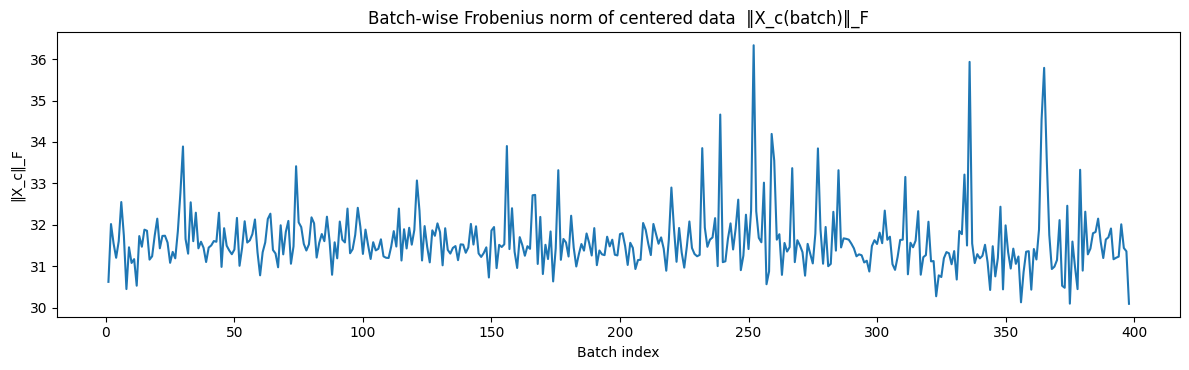

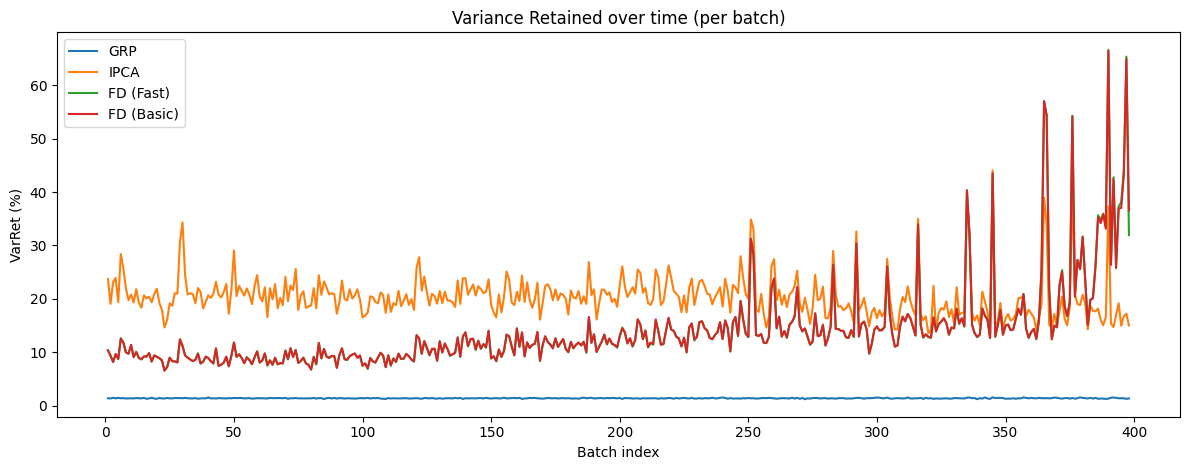

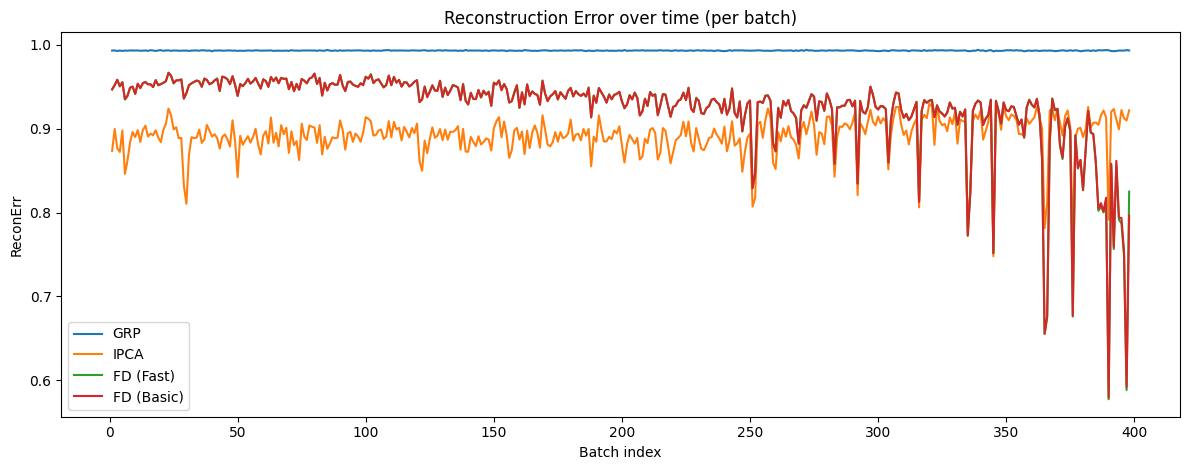


# Step 6
‖X_c‖_F per-batch:   min/med/max = (np.float64(30.090892949958647), np.float64(31.484964580837033), np.float64(36.33579104908783))
GRP         VarRet%  min/med/max = 1.18 / 1.36 / 1.55   |   ReconErr  min/med/max = 0.9922 / 0.9932 / 0.9941
IPCA        VarRet%  min/med/max = 13.03 / 20.02 / 44.05   |   ReconErr  min/med/max = 0.7480 / 0.8943 / 0.9326
FD (Fast)   VarRet%  min/med/max = 6.57 / 12.38 / 66.67   |   ReconErr  min/med/max = 0.5773 / 0.9361 / 0.9666
FD (Basic)  VarRet%  min/med/max = 6.53 / 12.44 / 66.45   |   ReconErr  min/med/max = 0.5793 / 0.9358 / 0.9668


In [17]:
# Step 6

algorithms = {
    "GRP": Q_grp,
    "IPCA": Q_ipca,
    "FD (Fast)": Q_fd_fast,
    "FD (Basic)": Q_fd_basic
}


def fro_norm(X):
    return float(np.linalg.norm(X, 'fro'))

def batch_Xc(i):

    start = i * BatchSize
    end   = min(start + BatchSize, len(DataStream))
    invs  = DataStream.iloc[start:end]['InvoiceNo'].astype(str).unique().tolist()
    X     = ItemTransactionMatrix.loc[invs].values.astype(float, copy=False)
    return X - mu_global

def varret_and_recon(Xc, Q):

    F = fro_norm(Xc)
    if F == 0:
        return 0.0, 0.0
    Fhat = fro_norm(Xc @ Q)
    VR   = (Fhat**2) / (F**2)
    RE   = np.sqrt(max(0.0, 1.0 - VR))
    return float(VR), float(RE)


F_base = []
VRs    = {name: [] for name in algorithms}
REs    = {name: [] for name in algorithms}

for i in range(BatchCount):
    Xc = batch_Xc(i)
    F_base.append(fro_norm(Xc))
    for name, Q in algorithms.items():
        vr, re = varret_and_recon(Xc, Q)
        VRs[name].append(vr)
        REs[name].append(re)

F_base = np.array(F_base)
t      = np.arange(1, BatchCount+1)


plt.figure(figsize=(12, 3.8))
plt.plot(t, F_base)
plt.title("Batch-wise Frobenius norm of centered data  ‖X_c(batch)‖_F")
plt.xlabel("Batch index"); plt.ylabel("‖X_c‖_F"); plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4.8))
for name in algorithms:
    plt.plot(t, np.array(VRs[name])*100, label=name)
plt.title("Variance Retained over time (per batch)")
plt.xlabel("Batch index"); plt.ylabel("VarRet (%)"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4.8))
for name in algorithms:
    plt.plot(t, REs[name], label=name)
plt.title("Reconstruction Error over time (per batch)")
plt.xlabel("Batch index"); plt.ylabel("ReconErr"); plt.legend(); plt.tight_layout()
plt.show()


def brief_stats(arr):
    arr = np.asarray(arr)
    return np.nanmin(arr), np.nanmedian(arr), np.nanmax(arr)

print("\n# Step 6")
print(f"‖X_c‖_F per-batch:   min/med/max = {brief_stats(F_base)}")
for name in algorithms:
    vmin, vmed, vmax = brief_stats(np.array(VRs[name])*100)
    rmin, rmed, rmax = brief_stats(REs[name])
    print(f"{name:10s}  VarRet%  min/med/max = {vmin:.2f} / {vmed:.2f} / {vmax:.2f}   |   "
          f"ReconErr  min/med/max = {rmin:.4f} / {rmed:.4f} / {rmax:.4f}")
